# Dopamine mediates the bidirectional update of interval timing: simulations

Anthony M.V. Jakob$^{1,2}$, John G. Mikhael$^{2,3}$, Allison E. Hamilos$^{2,3}$, John A. Assad$^{2,4}$, Samuel J. Gershman$^{5,6}$

$^1$Section of Life Sciences Engineering, École Polytechnique Fédérale de Lausanne, Switzerland  
$^2$Department of Neurobiology, Harvard Medical School, Boston, MA 02115  
$^3$MD-PhD Program, Harvard Medical School, Boston, MA 02115  
$^4$Istituto Italiano di Tecnologia, Genova, Italy  
$^5$Department of Psychology and Center for Brain Science, Harvard University, Cambridge, MA 02138  
$^6$Center for Brains, Minds and Machines, Massachusetts Institute of Technology, Cambridge, MA 02139  


In [1]:
include("src/fig1.jl")
include("src/td.jl")
include("src/td_eta.jl");

In [21]:
using Distributions

## Figure 1

In [25]:
# objective time
t = 1:100 |> collect

# reward time and schedule
T = 40
r = zeros(length(t)-1); r[T] = 1

# Gershman (2014) showed that ramping RPEs follow from convex functions
# or any other sufficiently convex function
V = t.^4
V[T+1:end] .= 0
# renormalize so maximum(V) = r[T]
V = V .* maximum(r) / maximum(V)  

# RPE
γ = .95
δ = r + γ*V[2:end] - V[1:end-1]

# account for temporal uncertainty following Weber's law
w = .2                         
k = hcat([pdf.(dist, t) for dist in Normal.(t, w .*t)]...)
k0 = k[1:end-1, 1:end-1]

# take convolution with uncertainty kernels
Vh = (V' * k)'
dh = (δ' * k0)'
Vdot = (diff(V)' * k0)'

# get baseline eta
η_base, Ys_base = TDeta(length(t)-1, T, 1, 1, Vh', r[T], γ)
η = η_base[end];

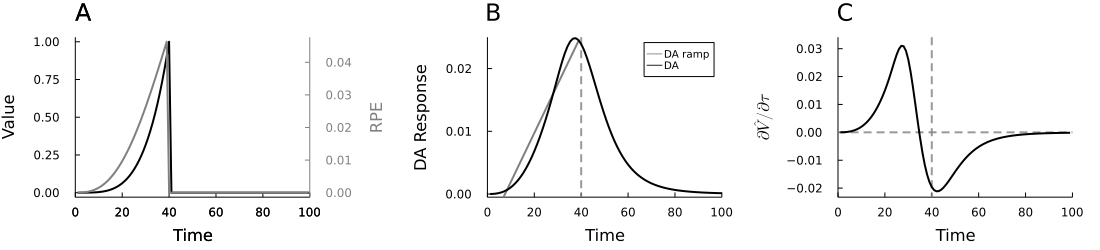

In [109]:
# Fig 1A: V and RPE
fig1A = plot_fig1A(t, V, δ)

# Fig 1B: DA with uncertainty
fig1B = plot_fig1B(t, dh, T, η)

# Fig 1C: Vdot
fig1C = plot_fig1C(t, Vdot, T) 

# Fig 1
fig1 = plot_fig1(fig1A, fig1B, fig1C)

#### Theoretical bidirectional plasticity function for non-ramping RPE

In [131]:
n = 100
y = 1:n |> collect
Y = 60
power = .7
η = 1
t = (y/η).^(1/power)
T = (Y/η)^(1/power)
γ = .9
σ = 5
alphaE = .1
r = 1

# learn value estimate Vh, against subjective time y
Vh, _ = TD(n, Y+1, σ, r, γ)

# derive RPE
δ = r .+ γ*Vh[2:end] - Vh[1:end-1]

# compute update rule for eta
dVdy = [0; (diff(Vh[1:end-1]) + diff(Vh[2:end]))/2]
dη = alphaE/η * y[1:end-1] .* δ .* dVdy
;

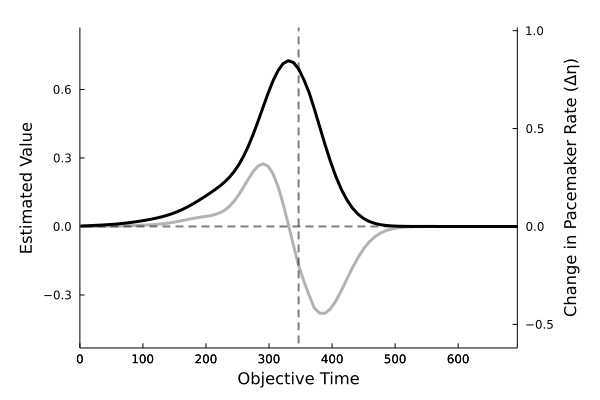

In [132]:
ylim = (min(minimum(Vh), minimum(dη)), max(maximum(Vh), maximum(dη)))

# plot main curves
params = Dict(:linewidth => 3, :label => "",)
plot(t, Vh,
    color=:black,
    ylabel="Estimated Value",
    ylim=1.2.*ylim;
    params..., twin_margins...)

p = twinx()
plot!(p, t[1:end-1], dη,
    color=:black,
    opacity=.3,  
    ylabel="Change in Pacemaker Rate (Δη)",
    ylim=1.4.*ylim;
    params..., twin_margins...)

# plot x=T and y=0
params = Dict(
    :color => :black,
    :opacity => .5,
    :linewidth => 2,
    :linestyle => :dash,
    :label => "",
)
hline!(p, [0]; params...
vline!(p, [T]; params...)
xlabel!(p, "Objective Time")

plot!(grid=:off, xlim=(0, 2*T),)